In [1]:

# Домашняя работа

#    Подробнее описание и данные находятся в файле Practice_1_2.ipynb (вложение Материалы к занятию). 
#    Это задание мы разберем на следующем занятии в кампусе. 
#
#    Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, 
#    где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
#     
#    Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения 
#    клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается 
#    значение канала привлечения)
#
#    При агрегации (pandas.DataFrame.groupby) по cl_id (или по связке cl_id, channel_type, target_flag) 
#    необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:
#       - общая сумма транзакций по каждой из trx_category
#       - общая сумма транзакции по основным вылютам (напр. выделить рубли, 
#         доллары и евро - предположительно, это будут самые крупные категории)
#       - общая сумма транзакций по категориям MCC кодов (например, выбрать 
#         основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут 
#         быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; 
#         Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории 
#         кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
#       - возможные агрегации по времени суток и дням недели - траты в выходные 
#         (праздники) или будни, в ночное время или в рабочее и т.д.
#         
#    Обязательная часть: провести первичный анализ данных - посмотреть распределения признаков, 
#    выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, 
#    какие категории транзакции (trx_category) наиболее популярны и т.д. 
#    Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
#     
#    Дополнительная часть: с отобранными фичами и полученными компонентами обучить модель 
#    (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном 
#    тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. 
#    Метрика оценки качества - ROC AUC(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
#     
#    Задания принимаются в виде ноутбука с кодов/картинками выполненной 
#    обязательной части + указанием места в leaderboard при решении дополнительной
#
#
#
#

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xgboost
from sklearn.metrics import roc_auc_score, roc_curve

/home/user/.local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [5]:
raw_df.channel_type.value_counts()

type1    299247
type2    175013
type5      5587
type4      4476
type3      3280
Name: channel_type, dtype: int64

In [6]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


In [7]:
raw_df[['cl_id','target_flag']].groupby('cl_id').mean().target_flag.value_counts()

1    2767
0    2233
Name: target_flag, dtype: int64

In [172]:
# Найдем самые популярные МСС коды
top_mcc = raw_df[['MCC','cl_id']].groupby('MCC').count().sort_values('cl_id', ascending=False).head(5).index.tolist()
top_mcc[:10]

[5411, 6011, 5814, 5812, 5499]

In [173]:
# используемые валюты
raw_df['currency'].value_counts().head(10)
# возмем первые 3 валюты остальные запишем с прочие

810    477644
978      5536
840      1921
933       561
985       423
764       412
203       399
949       390
975       297
826       267
Name: currency, dtype: int64

In [39]:
top_currency = raw_df['currency'].value_counts().index.tolist()[:3]
top_currency

[810, 978, 840]

In [40]:
# Добавление параметров в датасет

# день недели транзакции
def add_day(dataset):
    dataset['day'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w') )

# час суток транзакции      
def add_hour(dataset):
    dataset['hour'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H') )



    
# приход и выход денег ( разделим по типам транзакции 
# в приход пойдут  типы 'DEPOSIT', 'CASH_ADV' , 'C2C_IN',  'BACK_TRX'
# в выход идут 'C2C_OUT' 'CAT' 'POS'  'WD_ATM_OTHER' 'WD_ATM_PARTNER' 'WD_ATM_ROS')
trx_category_in = ['DEPOSIT', 'CASH_ADV' , 'C2C_IN',  'BACK_TRX']

def add_is_IN_column(dataset):
    dataset['is_IN'] = dataset['trx_category'].apply(lambda x: 1 if x in trx_category_in else 0)

def add_number_week(dataset): 
    dataset['week'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%W') )
    


In [41]:
def add_new_param(dataset):
    add_hour(dataset)             # добавим час
    add_day(dataset)              # добавим день
    add_is_IN_column(dataset)     # добавим направление 
    add_number_week(dataset)      # добавим недели 

In [42]:
add_new_param(raw_df)

In [43]:
import seaborn as sns

In [44]:
tmp_fd_hour = raw_df[['trx_category','hour','amount']].groupby(['trx_category','hour']).count().unstack(0).fillna(0)

In [45]:
tmp_fd_day = raw_df[['trx_category','day','amount']].groupby(['trx_category','day']).count().unstack(0).fillna(0)

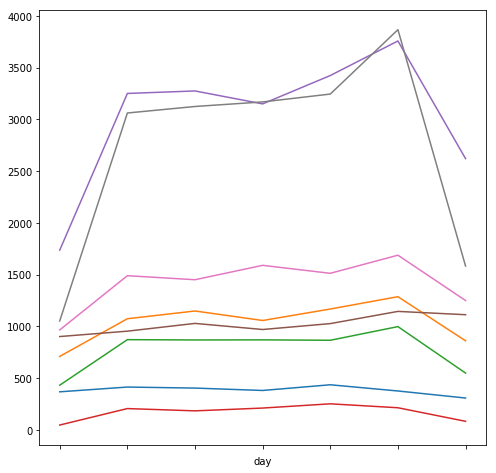

In [159]:
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
tmp_fd_day['amount'][['BACK_TRX','C2C_IN', 'C2C_OUT','CAT' ,'DEPOSIT','WD_ATM_OTHER','WD_ATM_PARTNER','WD_ATM_ROS']].plot(legend=False)

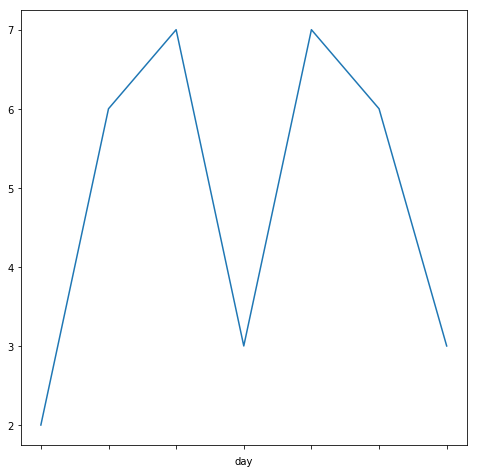

In [160]:
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
tmp_fd_day['amount'][['CASH_ADV']].plot(legend=False)

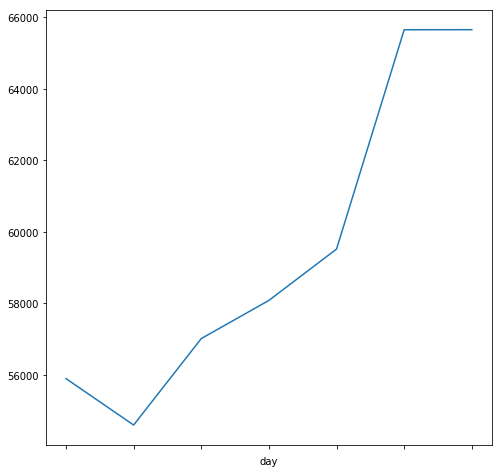

In [161]:
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
tmp_fd_day['amount'][['POS']].plot(legend=False)

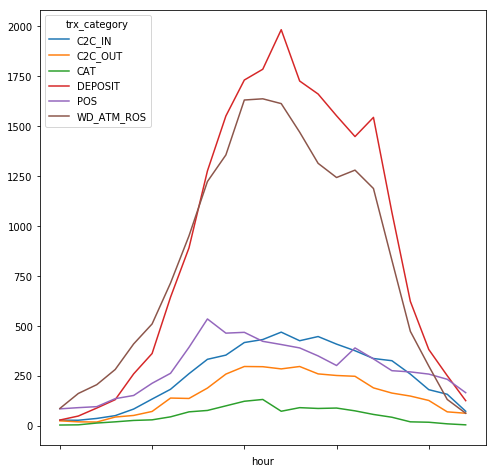

In [162]:
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
tmp_fd_hour[1:]['amount'][['C2C_IN','C2C_OUT', 'CAT','DEPOSIT' ,'POS','WD_ATM_ROS']].plot()

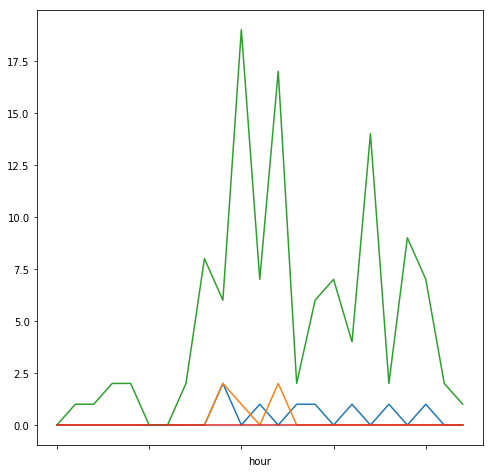

In [163]:
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
tmp_fd_hour[1:]['amount'][['BACK_TRX','CASH_ADV','WD_ATM_OTHER','WD_ATM_PARTNER']].plot(legend=False)

In [51]:
raw_df.head(1)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,hour,day,is_IN,week
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0,00,6,0,42


In [52]:
## Генерация новых фич
##
##  Все функции возвращают датасет сгруппированные по cl_id 
##

In [219]:

# Суммарные траты 
def all_amount(dataset, is_IN):
    dataset_cut = dataset[dataset['is_IN'] == is_IN]
    return dataset_cut[['cl_id', 'amount']].groupby('cl_id').sum().reset_index() 

## Средние величины 
# В неделю 
def mean_week(dataset, is_IN):
    dataset_cut = dataset[dataset['is_IN'] == is_IN]
    return dataset_cut[['cl_id','week', 'amount']].groupby(['cl_id','week']).sum().reset_index().groupby('cl_id')\
                  .mean().reset_index().rename(columns={'amount':'mean_week'})
# В выходные
def mean_weekend(dataset, is_IN):
    dataset_cut = dataset[dataset['is_IN'] == is_IN]
    return dataset_cut[dataset_cut['day'].isin(['5', '6'])][['cl_id','week', 'amount']].groupby(['cl_id','week'])\
                 .sum().reset_index().groupby('cl_id').mean().reset_index().rename(columns={'amount':'mean_weekend'})
# В будни
def mean_weekdays(dataset, is_IN):
    dataset_cut = dataset[dataset['is_IN'] == is_IN]
    return dataset_cut[dataset_cut['day'].isin(['1', '2', '3', '4'])][['cl_id','week', 'amount']].groupby(['cl_id','week'])\
                .sum().reset_index().groupby('cl_id').mean().reset_index().rename(columns={'amount':'mean_weekdays'})

# Траты по типам МСС (берем первые 30 типов отдельно, осталные в общее)
def amount_mcc(dataset, is_IN):
    dataset_cut = dataset[dataset['is_IN'] == is_IN]
    df1_s = dataset_cut[dataset_cut['MCC'].isin(top_mcc)][['cl_id', 'amount', 'MCC']].groupby(['cl_id', 'MCC'])\
        .sum().unstack().fillna(0).stack().reset_index().pivot(index='cl_id', columns='MCC', values='amount')\
        .reset_index()
    for col in list(set(top_mcc) - set(df1_s.columns.values.tolist())):
        df1_s[col]=0
    df1_c = dataset_cut[dataset_cut['MCC'].isin(top_mcc)][['cl_id', 'amount', 'MCC']].groupby(['cl_id', 'MCC'])\
        .count().unstack().fillna(0).stack().reset_index().pivot(index='cl_id', columns='MCC', values='amount')\
        .reset_index()
    for col in list(set(top_mcc) - set(df1_c.columns.values.tolist())):
        df1_c[col]=0
    df1_m = dataset_cut[dataset_cut['MCC'].isin(top_mcc)][['cl_id', 'amount', 'MCC']].groupby(['cl_id', 'MCC'])\
        .mean().unstack().fillna(0).stack().reset_index().pivot(index='cl_id', columns='MCC', values='amount')\
        .reset_index()
    for col in list(set(top_mcc) - set(df1_m.columns.values.tolist())):
        df1_m[col]=0
    df2_s = dataset_cut[~dataset_cut['MCC'].isin(top_mcc)][['cl_id', 'amount', 'MCC']].groupby(['cl_id', 'MCC'])\
        .sum().reset_index().groupby('cl_id').sum()['amount'].reset_index().rename(columns={'amount':'other_MCC_sum'})
    df2_c = dataset_cut[~dataset_cut['MCC'].isin(top_mcc)][['cl_id', 'amount', 'MCC']].groupby(['cl_id', 'MCC'])\
        .count().reset_index().groupby('cl_id').sum()['amount'].reset_index().rename(columns={'amount':'other_MCC'})
    df2_m = dataset_cut[~dataset_cut['MCC'].isin(top_mcc)][['cl_id', 'amount', 'MCC']].groupby(['cl_id', 'MCC'])\
        .mean().reset_index().groupby('cl_id').sum()['amount'].reset_index().rename(columns={'amount':'other_MCC_mean'})
    
    df1_s = df1_s.merge(df1_m,  how='outer', on='cl_id',suffixes=('_sum','_mean') )
    df1_s = df1_s.merge(df1_c,  how='outer', on='cl_id')
    df2_s = df2_s.merge(df2_m, how='outer', on='cl_id')
    df2_s = df2_s.merge(df2_c, how='outer', on='cl_id')
    df = df1_s.merge(df2_s, how='outer', on='cl_id').fillna(0)
    return df

# оборот по типам валют 
def amount_currency(dataset, is_IN):
    dataset_cut = dataset[dataset['is_IN'] == is_IN]
    t_c = top_currency.copy()
    tmp_df = dataset_cut[['cl_id','currency','amount']].groupby(['cl_id','currency']).sum()\
             .unstack().fillna(0).stack().reset_index()\
             .pivot(index='cl_id', columns='currency', values='amount').reset_index()
    for cur in list(set(t_c)-set(tmp_df.columns.values.tolist())):
        tmp_df[cur]=0
    res2 = tmp_df.drop(columns=t_c)
    res3 = pd.DataFrame(res2['cl_id'])
    res3['other_sum'] = res2.drop(columns=['cl_id']).apply(lambda x : x.sum(), axis=1)
    t_c.append('cl_id')
    res = tmp_df[t_c]
    res = res.merge(res3, how='outer', on='cl_id')
    return res

# количество транзакций по дням недели
def transaction_by_day_count(dataset):
    tmp_df = dataset.groupby(['cl_id','day'])['day'].size().unstack().fillna(0).reset_index()
    old_columns = [old_col for old_col in tmp_df.columns.tolist() if old_col in dataset['day'].unique()]
    tmp_df.rename(columns={old_col: 'day_' + old_col for old_col in old_columns}, inplace=True)
    return tmp_df

# количество транзакций по часам суток
def transaction_by_hour_count(dataset):
    return dataset.groupby(['cl_id','hour'])['hour'].size().unstack().fillna(0).reset_index()

# оборот по типам транзакции всего
def transaction_type_count(dataset):
    return dataset[['cl_id','trx_category','amount']].groupby(['cl_id','trx_category']).sum().unstack().fillna(0)\
                .stack().reset_index().pivot(index='cl_id', columns='trx_category', values='amount').reset_index()

# средний размер транзакции по типам 
def transaction_type_amount_mean(dataset): 
    return dataset[['cl_id','trx_category','amount']].groupby(['cl_id','trx_category']).mean().unstack().fillna(0)\
                 .stack().reset_index().pivot(index='cl_id', columns='trx_category', values='amount').reset_index()



# среднее время между транзакциями 
# и характеристики a и b регрессии вида y = a + bx для всех времен 
# (покажет растет ли в среднем время между транзакциями или уменьшается)

def mean_time_between_transactions(dataset, is_IN):
    i = 0
    dataset_cut = dataset[dataset['is_IN'] == is_IN]
    res = pd.DataFrame([],columns=['cl_id', 'mean_delay', 'lm_inter','lm_x'])
    for cl_id in dataset_cut['cl_id'].unique():
        temp_df = dataset_cut[dataset_cut['cl_id'] == cl_id]['TRDATETIME']\
                      .apply(lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S'))).sort_values()
        if len(temp_df) <2:
            res = res.append({'cl_id':int(cl_id),
                          'mean_delay':99999999.0, 
                          'lm_inter':0.0,
                          'lm_x':0.0}, ignore_index=True)
            continue    
        df1 = temp_df[:-1]
        df2 = temp_df[1:]
        df1 = pd.DataFrame(df1)
        df1 = df1.reset_index().drop(columns=['index'])
        df2 = pd.DataFrame(df2)
        df2 = df2.reset_index().drop(columns=['index'])
        df1.rename(columns={'TRDATETIME':'start'}, inplace=True)
        df2.rename(columns={'TRDATETIME':'next'}, inplace=True) 
        df3 = pd.concat([df1,df2.reset_index().drop(columns=['index'])],axis=1)
        df3['delay'] = df3['next']-df3['start']
        df3['delay'] = df3['delay'] + datetime.timedelta(seconds=1)
        df3['delay_sec'] = df3['delay'].apply(lambda x : x.total_seconds())
        
        df3 = df3.reset_index()
        est = smf.ols('delay_sec ~ index', df3).fit()
       
        res = res.append({'cl_id':int(cl_id),
                          'mean_delay':df3['delay_sec'].mean(), 
                          'lm_inter':est.params['Intercept'],
                          'lm_x':est.params['index']}, ignore_index=True)
                
    return res                                                                     

def get_one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

# закодировать категориальную переменную через one hot encoding 
# т.к. могут быть пропущенные значения, то временно заполним пропущенные значения, а после кодировки
# удалим колонку с созданным параметром
def encode_one_hot(dataset, cols):
    drop_cols=[]
    res = pd.DataFrame(dataset['cl_id'].unique(), columns=['cl_id'])
    for each in cols:
        copy_dataset = dataset[['cl_id', each]].copy()
        if copy_dataset[each].isnull().values.any():
            new_col = '_'.join(list(copy_dataset[each].value_counts().index))
            copy_dataset[each].fillna(new_col, inplace=True)
            drop_cols.append(each+'_'+new_col)
        copy_dataset = get_one_hot(copy_dataset,[each])
        res_tmp = copy_dataset.groupby('cl_id').mean()
        res = res.merge(res_tmp, how='left', on='cl_id')
    res.drop(columns=drop_cols, inplace=True)    
    return res    

# поле таргет
def getTarget(dataset):
    return dataset[['cl_id','target_flag']].groupby('cl_id').mean().reset_index()     
        
def getAllParams(dataset):
    res = all_amount(dataset, 0)
    res = res.merge(all_amount(dataset, 1), how='left', on='cl_id', suffixes=['_out','_in'])
    print('all_amount')
    res = res.merge(mean_week(dataset, 0), how='left', on='cl_id')
    res = res.merge(mean_week(dataset, 1), how='left', on='cl_id', suffixes=['_out','_in'])
    print('mean_week')
    res = res.merge(mean_weekend(dataset, 0), how='left', on='cl_id')
    res = res.merge(mean_weekend(dataset, 1), how='left', on='cl_id', suffixes=['_out','_in'])
    print('mean_weekend')
    res = res.merge(mean_weekdays(dataset, 0), how='left', on='cl_id')
    res = res.merge(mean_weekdays(dataset, 1), how='left', on='cl_id', suffixes=['_out','_in'])
    print('mean_weekdays')
    res = res.merge(amount_mcc(dataset, 0), how='left', on='cl_id')
    res = res.merge(amount_mcc(dataset, 1), how='left', on='cl_id', suffixes=['_out','_in'])
    print('amount_mcc')
    res = res.merge(amount_currency(dataset, 0), how='left', on='cl_id')
    res = res.merge(amount_currency(dataset, 1), how='left', on='cl_id', suffixes=['_out','_in'])
    print('amount_currency')
    res = res.merge(transaction_by_day_count(dataset), how='left', on='cl_id')
    print('transaction_by_day_count')
    res = res.merge(transaction_by_hour_count(dataset), how='left', on='cl_id')
    print('transaction_by_hour_count')
    res = res.merge(transaction_type_count(dataset), how='left', on='cl_id')
    print('transaction_type_count')
    res = res.merge(transaction_type_amount_mean(dataset), how='left', on='cl_id')
    print('transaction_type_amount_mean')
    res = res.merge(mean_time_between_transactions(dataset, 0), how='left', on='cl_id')
    print('mean_time_between_transactions 1')
    res = res.merge(mean_time_between_transactions(dataset, 1), how='left', on='cl_id')
    print('mean_time_between_transactions 2')
    res = res.merge(encode_one_hot(dataset, ['channel_type','hour']), how='left', on='cl_id', suffixes=['_out','_in'])
    print('encode_one_hot')
    if 'target_flag' in dataset:
        res = res.merge(getTarget(dataset), how='left', on='cl_id', suffixes=['_out','_in'])
    print('getTarget')
    res.fillna(0, inplace=True)
    return res




In [54]:
add_new_param(raw_df)


In [55]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 14 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
hour            490513 non-null object
day             490513 non-null object
is_IN           490513 non-null int64
week            490513 non-null object
dtypes: float64(2), int64(5), object(7)
memory usage: 52.4+ MB


In [220]:
new_df = getAllParams(raw_df)
new_df.head()

all_amount
mean_week
mean_weekend
mean_weekdays
amount_mcc
amount_currency
transaction_by_day_count
transaction_by_hour_count
transaction_type_count
transaction_type_amount_mean
mean_time_between_transactions 1
mean_time_between_transactions 2
encode_one_hot
getTarget


,cl_id,amount_out,amount_in,mean_week_out,mean_week_in,mean_weekend_out,mean_weekend_in,mean_weekdays_out,mean_weekdays_in,5411_sum_out,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,target_flag
0,0,44383.00,20000.0,14794.333333,20000.000000,7054.000000,0.0,18664.500000,20000.000000,2031.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0
1,1,172578.04,95000.0,13275.233846,95000.000000,12340.224286,0.0,5982.590000,0.000000,14629.46,...,0.000000,0.000000,0.000000,0.000000,0.019231,0.009615,0.000000,0.0,0.000000,0
2,5,402379.13,143990.0,28741.366429,47996.666667,8943.897143,0.0,17063.056154,65000.000000,44925.40,...,0.007042,0.007042,0.028169,0.035211,0.014085,0.000000,0.000000,0.0,0.000000,1
3,9,547365.09,301950.0,45613.757500,75487.500000,183.333333,87000.0,54395.900000,71650.000000,39.00,...,0.076923,0.051282,0.025641,0.051282,0.000000,0.025641,0.025641,0.0,0.076923,0
4,10,688043.99,436300.0,49145.999286,72716.666667,9265.965385,176500.0,14245.280769,13883.333333,53920.36,...,0.006479,0.008639,0.008639,0.000000,0.000000,0.002160,0.000000,0.0,0.000000,0


In [175]:
new_df.head()
 

,cl_id,amount_out,amount_in,mean_week_out,mean_week_in,mean_weekend_out,mean_weekend_in,mean_weekdays_out,mean_weekdays_in,5411_sum_out,...,lm_x_x,mean_delay_y,lm_inter_y,lm_x_y,channel_type_type1,channel_type_type2,channel_type_type3,channel_type_type4,channel_type_type5,target_flag
0,0,44383.00,20000.0,14794.333333,20000.000000,7054.000000,0.0,18664.500000,20000.000000,2031.00,...,1.790568e+06,1.000000e+08,0.000000e+00,0.000000,0,0,0,0,0,0
1,1,172578.04,95000.0,13275.233846,95000.000000,12340.224286,0.0,5982.590000,0.000000,14629.46,...,-1.350434e+03,6.800000e+01,6.800000e+01,0.000000,0,0,0,0,0,0
2,5,402379.13,143990.0,28741.366429,47996.666667,8943.897143,0.0,17063.056154,65000.000000,44925.40,...,-1.307787e+02,1.724026e+06,1.659535e+06,42993.600000,0,0,0,0,0,1
3,9,547365.09,301950.0,45613.757500,75487.500000,183.333333,87000.0,54395.900000,71650.000000,39.00,...,-2.549730e+03,8.208673e+05,5.833668e+05,237500.500000,0,0,0,0,0,0
4,10,688043.99,436300.0,49145.999286,72716.666667,9265.965385,176500.0,14245.280769,13883.333333,53920.36,...,7.541124e-01,2.339705e+05,2.992321e+05,-5674.921304,0,0,0,0,0,0


In [69]:
# посмотрим на распределение ненкоторых величин

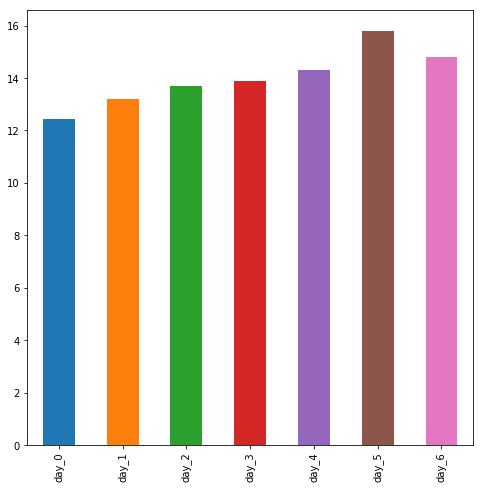

In [164]:
l = ['day_'+str(x) for x in range(7)]
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
new_df[l].mean().plot.bar()

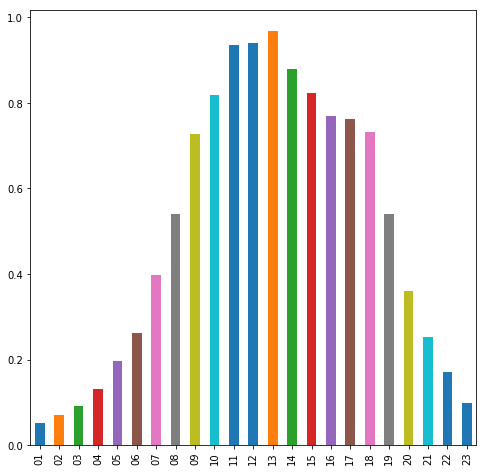

In [165]:
l = [str(x) if len(str(x))==2 else '0'+str(x) for x in range(1,24)]
new_df[l].mean().plot.bar()

/home/user/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/user/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


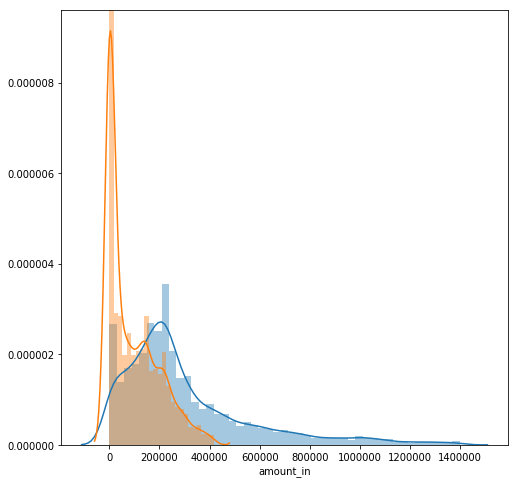

In [166]:
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
sns.distplot(new_df[new_df['amount_out'] < new_df['amount_out'].quantile(0.95)]['amount_out'])
sns.distplot(new_df[new_df['amount_in'] < new_df['amount_in'].quantile(0.95)]['amount_in'])

In [73]:
# Обучим несколько моделей

In [183]:
# Разделим выборку на тестовую и тренировочную
cl_ids_test = np.random.choice(new_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [221]:
# create transactions dataset for train
train = new_df[~new_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(train))
# create transactions dataset for test
test = new_df[new_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(test))

Total transactions in train dataset:  4000
Total transactions in test dataset:  1000


In [223]:
y_train = train['target_flag']
x_train = train.drop(columns=['target_flag','cl_id'])
y_test = test['target_flag']
x_test = test.drop(columns=['target_flag','cl_id'])


In [224]:
x_train = x_train.reset_index().drop(columns=['index'])
y_train = y_train.reset_index().drop(columns=['index'])
x_train.head()

,amount_out,amount_in,mean_week_out,mean_week_in,mean_weekend_out,mean_weekend_in,mean_weekdays_out,mean_weekdays_in,5411_sum_out,5499_sum_out,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,44383.00,20000.0,14794.333333,20000.000000,7054.000000,0.0,18664.500000,20000.0,2031.00,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,172578.04,95000.0,13275.233846,95000.000000,12340.224286,0.0,5982.590000,0.0,14629.46,492.8,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.019231,0.009615,0.000000,0.0,0.000000
2,402379.13,143990.0,28741.366429,47996.666667,8943.897143,0.0,17063.056154,65000.0,44925.40,7196.7,...,0.007042,0.007042,0.007042,0.028169,0.035211,0.014085,0.000000,0.000000,0.0,0.000000
3,547365.09,301950.0,45613.757500,75487.500000,183.333333,87000.0,54395.900000,71650.0,39.00,0.0,...,0.000000,0.076923,0.051282,0.025641,0.051282,0.000000,0.025641,0.025641,0.0,0.076923
4,245747.14,182000.0,17553.367143,36400.000000,9218.097143,28500.0,8488.989091,31250.0,31084.62,383.6,...,0.004608,0.009217,0.004608,0.013825,0.000000,0.009217,0.000000,0.000000,0.0,0.000000


In [225]:
# Линейный классификатор
s = list(x_train.columns.values)
x_train.head()

,amount_out,amount_in,mean_week_out,mean_week_in,mean_weekend_out,mean_weekend_in,mean_weekdays_out,mean_weekdays_in,5411_sum_out,5499_sum_out,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,44383.00,20000.0,14794.333333,20000.000000,7054.000000,0.0,18664.500000,20000.0,2031.00,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,172578.04,95000.0,13275.233846,95000.000000,12340.224286,0.0,5982.590000,0.0,14629.46,492.8,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.019231,0.009615,0.000000,0.0,0.000000
2,402379.13,143990.0,28741.366429,47996.666667,8943.897143,0.0,17063.056154,65000.0,44925.40,7196.7,...,0.007042,0.007042,0.007042,0.028169,0.035211,0.014085,0.000000,0.000000,0.0,0.000000
3,547365.09,301950.0,45613.757500,75487.500000,183.333333,87000.0,54395.900000,71650.0,39.00,0.0,...,0.000000,0.076923,0.051282,0.025641,0.051282,0.000000,0.025641,0.025641,0.0,0.076923
4,245747.14,182000.0,17553.367143,36400.000000,9218.097143,28500.0,8488.989091,31250.0,31084.62,383.6,...,0.004608,0.009217,0.004608,0.013825,0.000000,0.009217,0.000000,0.000000,0.0,0.000000


In [226]:
from sklearn.linear_model import RidgeClassifier

clf = RidgeClassifier(alpha=0.001).fit(x_train, y_train)
clf.score(x_train, y_train) 



/home/user/.local/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:810: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.73275

In [227]:
xgb = xgboost.XGBClassifier(max_depth=3, n_jobs=-1)
xgb.fit(x_train, y_train)
y_train_predict = xgb.predict_proba(x_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

/home/user/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train:  0.91
Test:  0.84


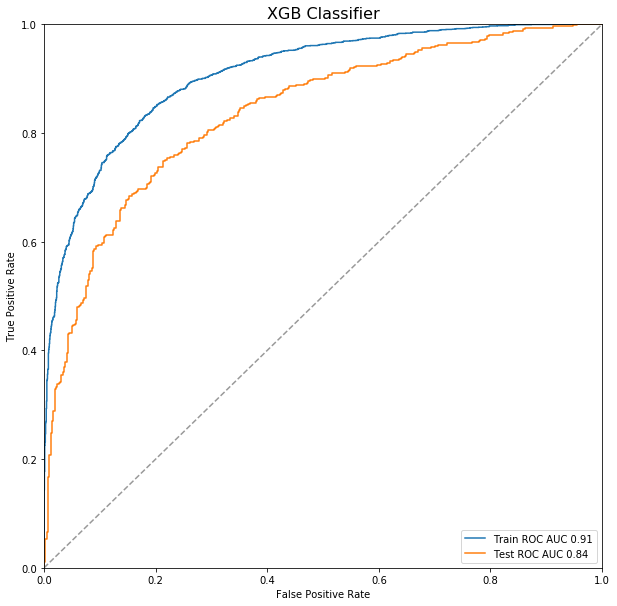

In [228]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

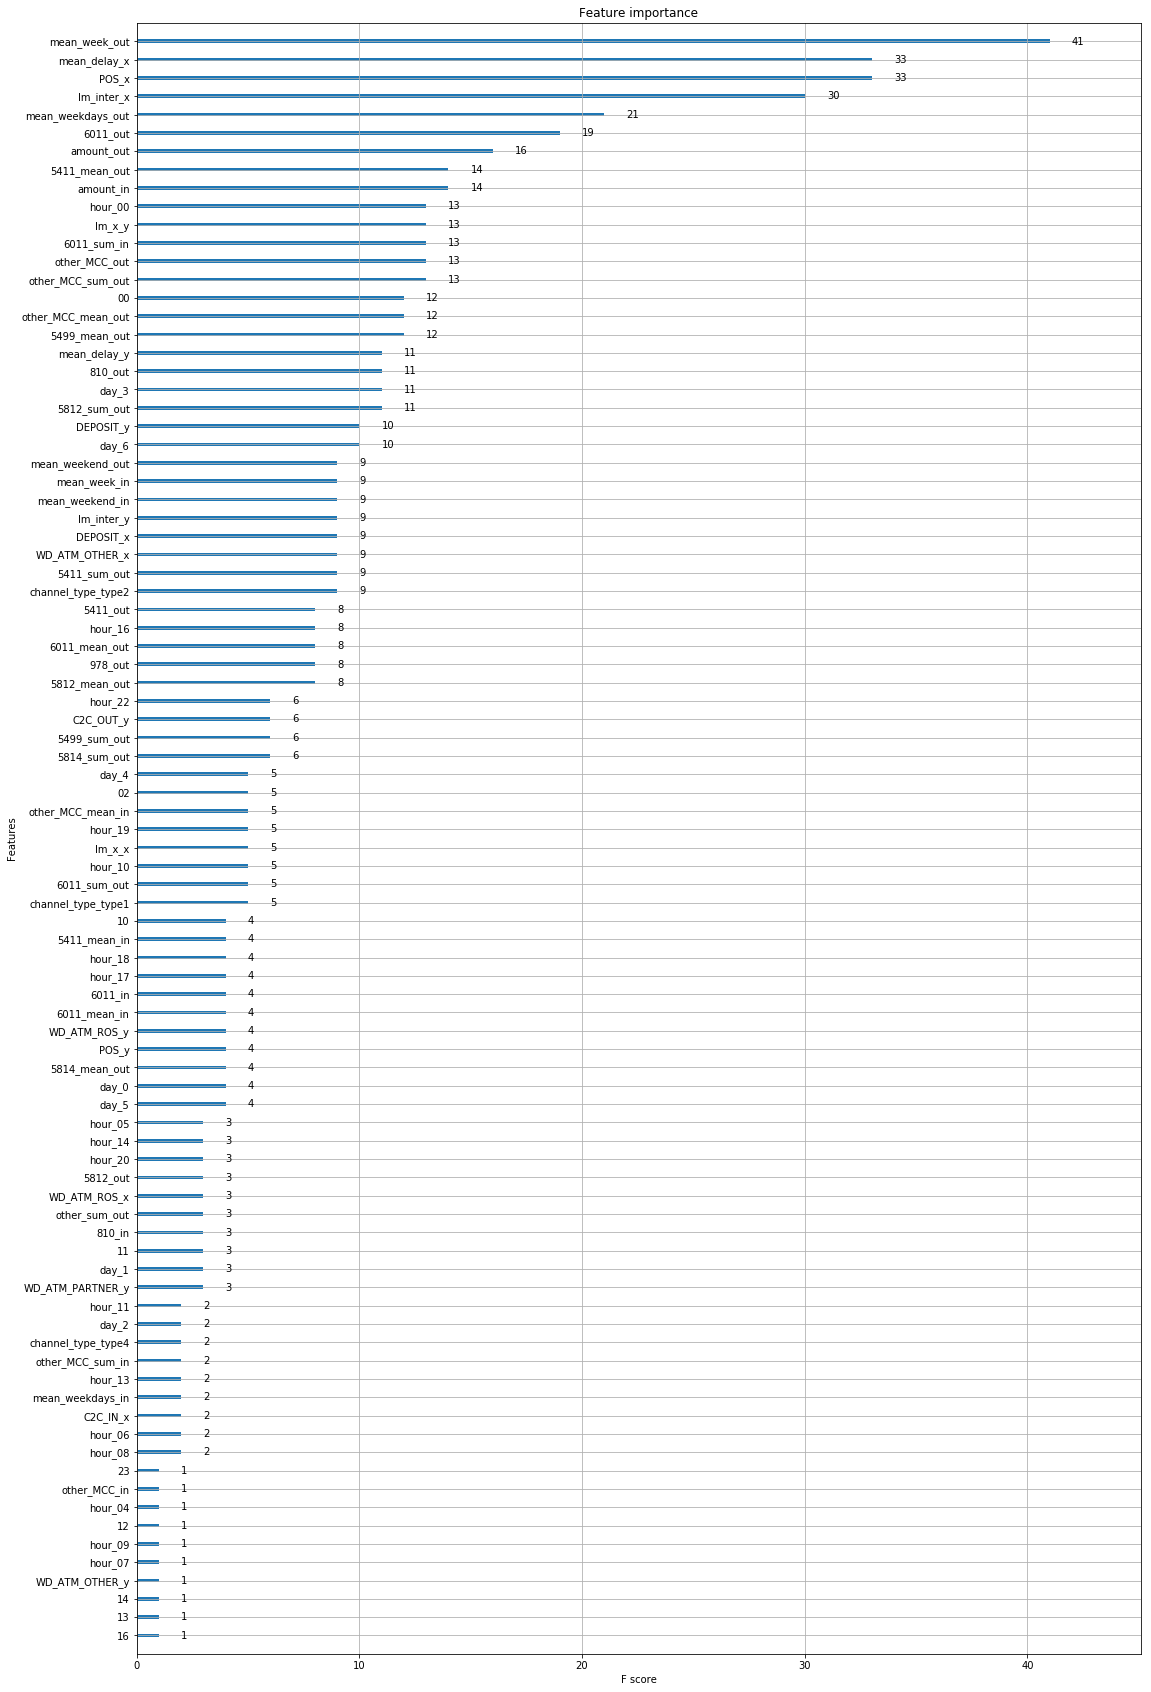

In [229]:
matplotlib.rcParams['figure.figsize'] = (18, 30)
xgboost.plot_importance(booster=xgb)
plt.savefig('tree_importance_test1.png')

In [230]:
raw_df_t = pd.read_csv('rosbank_test.csv')
raw_df_t.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category
0,01/04/2017,2,5814,NaN,810,18APR17:00:00:00,153.00,POS
1,01/03/2017,2,5812,NaN,810,10MAR17:00:00:00,388.08,POS
2,01/02/2017,2,5691,NaN,810,21FEB17:00:00:00,999.00,POS
3,01/04/2017,2,5814,NaN,810,26APR17:00:00:00,90.00,POS
4,01/04/2017,2,5814,NaN,810,08APR17:00:00:00,130.00,POS


In [231]:
add_new_param(raw_df_t)

In [232]:
new_df_t = getAllParams(raw_df_t)
new_df_t.head()

all_amount
mean_week
mean_weekend
mean_weekdays
amount_mcc
amount_currency
transaction_by_day_count
transaction_by_hour_count
transaction_type_count
transaction_type_amount_mean
mean_time_between_transactions 1
mean_time_between_transactions 2
encode_one_hot
getTarget


,cl_id,amount_out,amount_in,mean_week_out,mean_week_in,mean_weekend_out,mean_weekend_in,mean_weekdays_out,mean_weekdays_in,5411_sum_out,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,2,323977.72,4740.0,23141.265714,2370.000000,8321.490909,0.0,15835.124615,2370.000000,2383.84,...,0.015075,0.005025,0.005025,0.005025,0.005025,0.000000,0.005025,0.000000,0.000000,0.000000
1,3,195848.77,75000.0,17804.433636,37500.000000,6224.418182,45000.0,11328.844000,30000.000000,14144.27,...,0.041667,0.020833,0.000000,0.020833,0.000000,0.010417,0.020833,0.000000,0.010417,0.010417
2,4,338177.98,0.0,37575.331111,0.000000,26219.401111,0.0,7825.684444,0.000000,59104.24,...,0.025316,0.000000,0.000000,0.006329,0.000000,0.000000,0.000000,0.006329,0.000000,0.000000
3,6,440096.84,20780.0,33853.603077,6926.666667,11613.295455,0.0,21504.217692,6926.666667,30003.95,...,0.008032,0.008032,0.016064,0.020080,0.008032,0.024096,0.008032,0.000000,0.000000,0.000000
4,7,181497.93,12745.5,12964.137857,6372.750000,2599.102308,0.0,10154.823077,6372.750000,17040.07,...,0.000000,0.005814,0.005814,0.017442,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [233]:
'cl_id' in new_df_t.columns

True

In [234]:
new_df_test = new_df_t.drop(columns=['cl_id'])
new_df_test.head()


,amount_out,amount_in,mean_week_out,mean_week_in,mean_weekend_out,mean_weekend_in,mean_weekdays_out,mean_weekdays_in,5411_sum_out,5499_sum_out,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,323977.72,4740.0,23141.265714,2370.000000,8321.490909,0.0,15835.124615,2370.000000,2383.84,0.00,...,0.015075,0.005025,0.005025,0.005025,0.005025,0.000000,0.005025,0.000000,0.000000,0.000000
1,195848.77,75000.0,17804.433636,37500.000000,6224.418182,45000.0,11328.844000,30000.000000,14144.27,132.00,...,0.041667,0.020833,0.000000,0.020833,0.000000,0.010417,0.020833,0.000000,0.010417,0.010417
2,338177.98,0.0,37575.331111,0.000000,26219.401111,0.0,7825.684444,0.000000,59104.24,96.00,...,0.025316,0.000000,0.000000,0.006329,0.000000,0.000000,0.000000,0.006329,0.000000,0.000000
3,440096.84,20780.0,33853.603077,6926.666667,11613.295455,0.0,21504.217692,6926.666667,30003.95,3626.13,...,0.008032,0.008032,0.016064,0.020080,0.008032,0.024096,0.008032,0.000000,0.000000,0.000000
4,181497.93,12745.5,12964.137857,6372.750000,2599.102308,0.0,10154.823077,6372.750000,17040.07,109.00,...,0.000000,0.005814,0.005814,0.017442,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [235]:
print(len(list(new_df_test.columns)))
print(len(list(x_train.columns)))
print(len(set(x_train.columns)))

138
138
138


In [236]:
set(list(new_df.columns))-set(list(new_df_t.columns))

{'target_flag'}

In [237]:
new_df_test.head()

,amount_out,amount_in,mean_week_out,mean_week_in,mean_weekend_out,mean_weekend_in,mean_weekdays_out,mean_weekdays_in,5411_sum_out,5499_sum_out,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,323977.72,4740.0,23141.265714,2370.000000,8321.490909,0.0,15835.124615,2370.000000,2383.84,0.00,...,0.015075,0.005025,0.005025,0.005025,0.005025,0.000000,0.005025,0.000000,0.000000,0.000000
1,195848.77,75000.0,17804.433636,37500.000000,6224.418182,45000.0,11328.844000,30000.000000,14144.27,132.00,...,0.041667,0.020833,0.000000,0.020833,0.000000,0.010417,0.020833,0.000000,0.010417,0.010417
2,338177.98,0.0,37575.331111,0.000000,26219.401111,0.0,7825.684444,0.000000,59104.24,96.00,...,0.025316,0.000000,0.000000,0.006329,0.000000,0.000000,0.000000,0.006329,0.000000,0.000000
3,440096.84,20780.0,33853.603077,6926.666667,11613.295455,0.0,21504.217692,6926.666667,30003.95,3626.13,...,0.008032,0.008032,0.016064,0.020080,0.008032,0.024096,0.008032,0.000000,0.000000,0.000000
4,181497.93,12745.5,12964.137857,6372.750000,2599.102308,0.0,10154.823077,6372.750000,17040.07,109.00,...,0.000000,0.005814,0.005814,0.017442,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [238]:

new_df_test = new_df_test[x_train.columns]

In [239]:
y_test_predict = xgb.predict(new_df_test, ntree_limit=0)

/home/user/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [240]:
y_test_predict.reshape(5217,1) 

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [241]:
x = pd.concat([pd.DataFrame(new_df_t['cl_id']), pd.DataFrame(y_test_predict)], axis=1)
x.head()

,cl_id,0
0,2,1
1,3,1
2,4,1
3,6,1
4,7,1


In [242]:
x.rename(columns={'cl_id':'_ID_',0:'_VAL_'}, inplace=True)

In [243]:
x.head()

,_ID_,_VAL_
0,2,1
1,3,1
2,4,1
3,6,1
4,7,1


In [244]:
x.to_csv('res.csv', columns=['_ID_' ,'_VAL_'], index=False)

In [245]:
len(set(new_df['cl_id'].values) - set(new_df_t['cl_id'].values))

5000